<a href="https://colab.research.google.com/github/kis-balazs/machine-learning/blob/main/traj-pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
from typing import Any, Tuple
from itertools import chain, repeat, islice

from time import time

In [106]:
import numpy as np
import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [107]:
import folium
from IPython.display import display

In [108]:
from google.colab import drive
drive.mount('/content/drive')

# go to traj-pred folder
%cd "/content/drive/MyDrive/### research ###/trajectory-prediction"
# %ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/### research ###/trajectory-prediction


# utils

In [109]:
def plot_trajectory(traj: np.array, pre_map=None, color: str = 'blue', marker: bool = None) -> None:
    # Load map centred on average coordinates if there is a
    # pre-initialized map already
    if not pre_map:
        my_map = folium.Map(
            location=[np.average(traj[:, 0]), np.average(traj[:, 1])],
            zoom_start=14
        )
    else:
        my_map = pre_map
    
    # add a marker for first coordinate of the trajectory
    if marker:
        folium.Marker([traj[0][0], traj[0][1]]).add_to(my_map)
    
    # add trajectory polyline
    folium.PolyLine(
        traj, color=color, weight=2.5, opacity=1
    ).add_to(my_map)

    return my_map

def plot_trajectories(t1s: np.array = None, t2s: np.array = None, marker: bool = None) -> None:
    my_map = None
    # run the trajectory list to plot on the same map
    if t1s is not None:
        for traj in t1s:
            my_map = plot_trajectory(
                traj=traj,
                pre_map=my_map,
                color='blue',
                marker=marker
            )
    if t2s is not None:
        for traj in t2s:
            my_map = plot_trajectory(
                traj=traj,
                pre_map=my_map,
                color='red',
                marker=marker
            )
    display(my_map)

---
# preprocessing

In [110]:
SEQ_LEN = 15

---

---
- **trajectories.npy** => 3-dimensional array containing SEQ_LEN-long [lat x lon] GPS coordinate trajectories 

- **calibrated-trajectories.npy** => 3-dimensional array containint SEQ_len-long [vert_distance x horiz_distance] arrays, showing distance to previous coordinate. *Note*: first value is [0, 0] since it is the first, and corresponds to the first value from trajectories.npy. Using mloc.GeoLoc, calibrated trajectories can be converted back to trajectories, with precision.

In [111]:
ds = np.load('trajectories.npy', allow_pickle=True)
c_ds = np.load('calibrated-trajectories.npy', allow_pickle=True)

print('DS:', ds.shape)
print('Calibrated DS:', c_ds.shape)

assert ds.shape[0] == c_ds.shape[0]
assert ds[0].shape == c_ds[0].shape

DS: (1600466,)
Calibrated DS: (1600466, 15, 2)


In [112]:
# highly relevant dtype change, for the ML maths
c_ds = c_ds.astype('float32')

In [113]:
plot_trajectories(
    t1s=ds[:1_000],
    marker=False
)

---
---
## Trajectory Calibration

# **!! No need to execute, if calibrated-trajectories.npy exists!**

### MLoc

In [114]:
!pip install geographiclib --quiet

In [115]:
"""
Class to handle a tuple of lat x lon values as a coordinate, given an operating manifold.
Default manifold is WGS84.

The GeoLoc can be shifted along the Cartesian axes, and distances can be computed
from/to different other GeoLoc destinations.
"""
from typing import Tuple, Union

import numpy as np
from geographiclib.geodesic import Geodesic

__all__ = ['GeoLoc']


class GeoLoc:
    # azimuth variables for pointing the general direction of movement on operating manifold
    E = 90.0
    N = 0.0

    # constants
    PRECISION = 3

    def __init__(self, coord: Union[float, list, np.ndarray, tuple], lon: float = None) -> None:
        """
        :param coord: [list | ndarray | tuple] of lat & lon values, or latitude parameter
        :param lon: optional longitude coordinate. Not needed if p1 is list
        :return: None"""
        if type(coord) in [list, np.ndarray, tuple]:
            lat = coord[0]
            lon = coord[1]
        else:
            lat = coord

        self.lat = lat
        self.lon = lon
        # define the (world coordinate system) geodesic as operating manifold
        self.__geod = Geodesic.WGS84

    def __repr__(self) -> str:
        """Function to print a representation of the object as a geo-location.

        :return: string representation of the instance"""
        return f"({self.lat:.10f}, {self.lon:.10f})"

    # ### Distance functions ###
    def distance(self, dst: 'GeoLoc') -> float:
        """Function to compute the distance between the src (self) and destination GeoLoc objects,
        millimeter precision

        :param dst: destination GeoLoc
        :return: distance between source (self) and destination GeoLocs. In meters, mm precision"""
        assert isinstance(dst, GeoLoc), 'parameter NOT GeoLoc type'

        result = self.__geod.Inverse(self.lat, self.lon, dst.lat, dst.lon)
        return round(result['s12'], GeoLoc.PRECISION)

    def decomposed_distance(self, dst: 'GeoLoc') -> Tuple[float, float]:
        """Function to compute the distance between the src (self) and destination GeoLoc objects,
        and return it as a decomposition of two distances along the Cartesian axes.

        :param dst: destination GeoLoc
        :return: distance between geo-location and target coord. in format (vert~lat, horiz~lon)"""
        assert isinstance(dst, GeoLoc), 'parameter NOT GeoLoc type'

        vert_result = self.__geod.Inverse(self.lat, self.lon, dst.lat, self.lon)
        vert_sign = -1 if self.lat < dst.lat else 1
        horiz_result = self.__geod.Inverse(self.lat, self.lon, self.lat, dst.lon)
        horiz_sign = -1 if self.lon < dst.lon else 1

        return (
            vert_sign * round(vert_result['s12'], GeoLoc.PRECISION),  # vert
            horiz_sign * round(horiz_result['s12'], GeoLoc.PRECISION)  # horiz
        )

    # ### Distance functions ###

    # ### Shifting functions ###
    def __shift(self, direction: float, meters: float = 0.0) -> None:
        """Function to shift the current geo-loc in the specified direction on
        the geodesic by the specified dist. in meters.
        Internal (lat, lon) variables will be updated.

        :param direction: based on the given direction azimuth the coordinate
        shift will happen along an a specific axis
        :param meters: the amount of shift in the specified direction
        :return: None"""
        result = self.__geod.Direct(self.lat, self.lon, direction, s12=meters)

        # verify the shift distance by checking it in the returned geodesic dict
        assert float(result['s12']) == meters
        self.lat = result['lat2']
        self.lon = result['lon2']

    def shift_horizontal(self, meters: float = 0.0) -> None:
        """Function to shift the current GeoLoc East(pos) - West(neg) on the
        geodesic by the specified dist. In meters.
        Internal (lat, lon) variables will be updated.

        :param meters: the amount of shift East
        :return: None"""
        self.__shift(direction=GeoLoc.E, meters=meters)

    def shift_vertical(self, meters: float = 0.0) -> None:
        """Function to shift the current GeoLoc South(pos) - North(neg) on the
        geodesic by the specified dist. In meters.
        Internal (lat, lon) variables will be updated.

        :param meters: the amount of shift North
        :return: None"""
        self.__shift(direction=GeoLoc.N, meters=meters)
    # ### Shifting functions ###

### (Re)calibration of trajectory data in 0-centered start, with consecutive distance array
The trajectory will become an array of relative distances from the previous GPS coordinate. This way the coordinate system becomes unified and standard.

This iteration seems reasonable yet still highly rependant on the street structure, evaluatoin will explain usefulness.

In [61]:
def calibrate_trajectory(traj: np.array) -> np.array:
    t = [GeoLoc(coord) for coord in traj]
    dt = [[0.0, 0.0]]
    for idx in range(1, len(t)):
        dt += [t[idx].decomposed_distance(t[idx - 1])]
    return np.array(dt)

#### calibrate one trajectory

In [62]:
INDEX = 0

In [63]:
ds[INDEX]

array([[41.14141 , -8.618643],
       [41.141376, -8.618499],
       [41.14251 , -8.620326],
       [41.143814, -8.622153],
       [41.144375, -8.623953],
       [41.14478 , -8.62668 ],
       [41.144695, -8.627373],
       [41.14521 , -8.630226],
       [41.14692 , -8.632746],
       [41.148224, -8.631738],
       [41.150387, -8.629938],
       [41.151215, -8.62911 ],
       [41.15124 , -8.629128],
       [41.152203, -8.628786],
       [41.152374, -8.628687]], dtype=float32)

In [64]:
st = time()
_t = calibrate_trajectory(ds[INDEX])
print('timed:', time() - st)

timed: 0.005690097808837891


In [65]:
_t

array([[   0.   ,    0.   ],
       [  -3.813,   12.09 ],
       [ 125.823, -153.404],
       [ 144.887, -153.401],
       [  62.276, -151.077],
       [  44.907, -228.977],
       [  -9.32 ,  -58.125],
       [  57.192, -239.543],
       [ 189.794, -211.516],
       [ 144.888,   84.621],
       [ 240.208,  151.064],
       [  91.932,   69.487],
       [   2.966,   -1.521],
       [ 106.759,   28.739],
       [  19.064,    8.325]])

Start of ds[0] visualized:

Home and end(star) marked on the map. See correlation to decomposed distances.

![ds[0].png](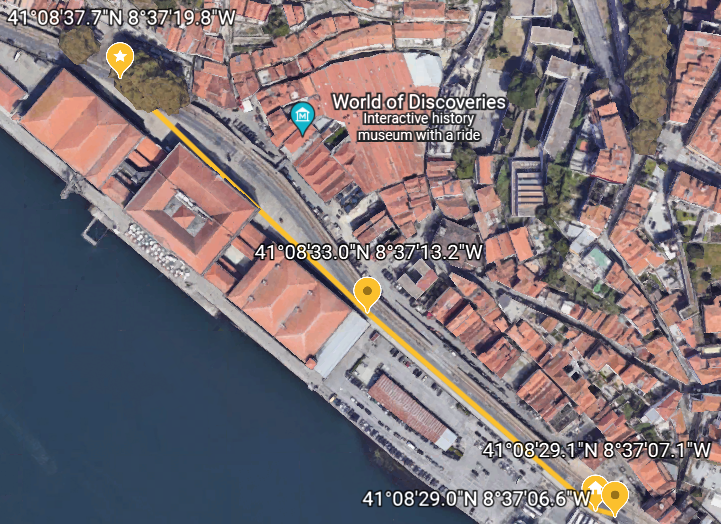)

#### calibrate all trajectories

In [66]:
# from multiprocessing.pool import Pool

# st = time()
# c_ds = []
# with Pool() as pool:
#     # execute tasks in order
#     for result in pool.map(calibrate_trajectory, ds):
#         assert(result.shape == (15, 2))
#         c_ds += [result]
# c_ds = np.array(c_ds)
# print('timed:', time() - st)

In [67]:
# np.save('calibrated-trajectories.npy', c_ds)

In [68]:
# c_ds.shape

---
## ML dataloader generation

In [116]:
# filter out outliers, with consecutive distances more than 400 meters

DS, C_DS = [], []
for t in range(len(c_ds)):
    if c_ds[t].max() < 400.0:
        DS += [ds[t]]
        C_DS += [c_ds[t]]

DS = np.array(DS)
C_DS = np.array(C_DS)
assert C_DS.shape == DS.shape

print(C_DS.shape)

(1556126, 15, 2)


In [117]:
C_DS_MAX = C_DS.max()
print(C_DS_MAX)

C_DS /= C_DS_MAX

399.996


In [118]:
splitter = lambda dataset, pivot: len(dataset) * pivot // 10

# ###
def train_val_test_split(d):
    # tr: train, v: validation, t: test
    split = splitter(d, 9)
    tr, t = d[:split], d[split:]

    tr_split = splitter(tr, 8)
    tr, v = tr[:tr_split], tr[tr_split:]

    return tr, v, t

# ###
train, val, test = train_val_test_split(C_DS)
_, _, orig_test = train_val_test_split(DS)

print('Train:', train.shape)
print('Val:', val.shape)
print('\nTest:', test.shape)

assert test.shape == orig_test.shape
assert train.shape[0] + val.shape[0] + test.shape[0] == C_DS.shape[0]

Train: (1120410, 15, 2)
Val: (280103, 15, 2)

Test: (155613, 15, 2)


In [119]:
train_loader = DataLoader(train, batch_size=256, shuffle=True)
val_loader = DataLoader(val, batch_size=128, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

orig_test_loader = DataLoader(orig_test, batch_size=64, shuffle=False)

# model

In [120]:
def init_hidden(batch_size: int, hidden_size: int, device) -> Tuple[Any, Any]:
    return (
        torch.zeros(batch_size, hidden_size).to(device),
        torch.zeros(batch_size, hidden_size).to(device),
    )

In [121]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size: int = 2, embedding_size: int = 4, hidden_size: int = 1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(input_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)

    def forward(self, x: torch.FloatTensor, hidden: Any) -> Any:
        embedded = F.relu(self.linear1(x))
        hidden = self.lstm1(embedded, hidden)
        return hidden


class DecoderRNN(nn.Module):
    def __init__(self, embedding_size=4, hidden_size=1, output_size=2):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(output_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        embedded = F.relu(self.linear1(x))
        hidden = self.lstm1(embedded, hidden)
        output = self.linear2(hidden[0])
        return output, hidden

# process functions

In [122]:
def train(
        train_loader: Any,
        epoch: int,
        criterion: Any,
        encoder: Any,
        decoder: Any,
        encoder_optimizer: Any,
        decoder_optimizer: Any,
        rollout_len: int = 10,
        device='cuda' if torch.cuda.is_available() else 'cpu'
) -> None:
    encoder.to(device)
    encoder.train()
    decoder.to(device)
    decoder.train()

    print('#' * 20)
    print(f"# Epoch: {epoch}")
    for i, _input in enumerate(train_loader):
        target = _input[:, 10:, :].to(device)
        _input = _input[:, :10, :].to(device)

        # Zero the gradients
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Encoder
        batch_size = _input.shape[0]
        input_length = _input.shape[1]
        output_length = target.shape[1]

        # Initialize encoder hidden state
        encoder_hidden = init_hidden(
            batch_size,
            encoder.hidden_size,
            device=device
        )

        # Initialize losses
        loss = 0

        # Encode observed trajectory
        for ei in range(input_length):
            encoder_input = _input[:, ei, :]
            encoder_hidden = encoder(
                encoder_input,
                encoder_hidden
            )

        # Initialize decoder input with last coordinate in encoder
        decoder_input = encoder_input[:, :2]

        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden

        decoder_outputs = torch.zeros(target.shape).to(device)

        # Decode hidden state in future trajectory
        for di in range(output_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input,
                decoder_hidden
            )
            decoder_outputs[:, di, :] = decoder_output

            # Update loss
            loss += criterion(decoder_output[:, :2], target[:, di, :2])

            # Use own predictions as inputs at next step
            decoder_input = decoder_output

        # Get average loss for pred_len
        loss = loss / rollout_len

        # Backpropagate
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        if i % 1_000 == 0:
            print('    - step: {:5}, loss: {}'.format(i, loss))

In [123]:
def validate(
        val_loader: Any,
        epoch: int,
        criterion: Any,
        encoder: Any,
        decoder: Any,
        encoder_optimizer: Any,
        decoder_optimizer: Any,
        prev_loss: float,
        incr_counter: int,
        rollout_len: int = 10,
        device='cuda' if torch.cuda.is_available() else 'cpu'
) -> Tuple[float, int]:
    encoder.to(device)
    encoder.eval()
    decoder.to(device)
    decoder.eval()

    global best_loss
    total_loss = []

    for i, (_input) in enumerate(val_loader):
        target = _input[:, 10:, :].to(device)
        _input = _input[:, :10, :].to(device)

        # Encoder
        batch_size = _input.shape[0]
        input_length = _input.shape[1]
        output_length = target.shape[1]

        # Initialize encoder hidden state
        encoder_hidden = init_hidden(
            batch_size,
            encoder.hidden_size,
            device=device
        )

        # Initialize loss
        loss = 0

        # Encode observed trajectory
        for ei in range(input_length):
            encoder_input = _input[:, ei, :]
            encoder_hidden = encoder(encoder_input, encoder_hidden)

        # Initialize decoder input with last coordinate in encoder
        decoder_input = encoder_input[:, :2]

        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden

        decoder_outputs = torch.zeros(target.shape).to(device)


        # Decode hidden state in future trajectory
        for di in range(output_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input,
                decoder_hidden
            )
            decoder_outputs[:, di, :] = decoder_output

            # Update losses for all benchmarks
            loss += criterion(decoder_output[:, :2], target[:, di, :2])

            # Use own predictions as inputs at next step
            decoder_input = decoder_output

        # Get average loss for pred_len
        loss = loss / output_length
        total_loss.append(loss)

    # Save
    val_loss = sum(total_loss) / len(total_loss)
    print(' == Val: loss: {}'.format(val_loss))

    if val_loss <= best_loss:
        print('|- Saving new state of enc & dec')
        torch.save(encoder.state_dict(), "enc.pt.tar")
        torch.save(decoder.state_dict(), "dec.pt.tar")

    # Keep track of the loss for early stop
    if val_loss < prev_loss:
        print('|- Early stop reset')
        incr_counter = 0
    else:
        print('|- Early stopping increment')
        incr_counter += 1

    return val_loss, incr_counter

In [124]:
def infer(
        test_loader: torch.utils.data.DataLoader,
        orig_test_loader: torch.utils.data.DataLoader,
        encoder: EncoderRNN,
        decoder: DecoderRNN,
        pred_len: int = 10,
        device='cuda' if torch.cuda.is_available() else 'cpu'
) -> None:
    encoder.to(device)
    encoder.eval()
    decoder.to(device)
    decoder.eval()

    forecasted_trajectories = []
    with torch.no_grad():
        for i, (_input, _orig_input) in enumerate(zip(test_loader, orig_test_loader)):
            _input = _input.to(device)

            # Encoder
            batch_size = _input.shape[0]
            input_length = _input.shape[1]

            # Initialize encoder hidden state
            encoder_hidden = init_hidden(
                batch_size,
                encoder.hidden_size,
                device=device
            )

            # Encode observed trajectory
            for ei in range(input_length):
                encoder_input = _input[:, ei, :]
                encoder_hidden = encoder(encoder_input, encoder_hidden)

            # Initialize decoder input with last coordinate in encoder
            decoder_input = encoder_input[:, :2]

            # Initialize decoder hidden state as encoder hidden state
            decoder_hidden = encoder_hidden

            decoder_outputs = torch.zeros((batch_size, pred_len, 2)).to(device)

            # Decode hidden state in future trajectory
            for di in range(pred_len):
                decoder_output, decoder_hidden = decoder(
                    decoder_input,
                    decoder_hidden
                )
                decoder_outputs[:, di, :] = decoder_output

                # Use own predictions as inputs at next step
                decoder_input = decoder_output

            forecasted_trajectories.append({
                'i': _input.cpu().detach().numpy(),
                'orig_i': _orig_input.detach().numpy(),
                'o': decoder_outputs.cpu().detach().numpy()
            })
    return forecasted_trajectories

---
# main

In [125]:
EPOCHS = 100

# ###
encoder = EncoderRNN(
    input_size=2
)
decoder = DecoderRNN(
    output_size=2
)

# optimizer
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-4)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4)
# criterion
criterion = nn.MSELoss()

In [126]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## training

In [ ]:
best_loss = float("inf")
prev_loss = best_loss

# early stopping increment counter
incr_counter = 0

for epoch in np.arange(EPOCHS):
    train(
        train_loader,
        epoch,
        criterion,
        encoder,
        decoder,
        encoder_optimizer,
        decoder_optimizer,
        rollout_len=SEQ_LEN,
        device=device
    )
    prev_loss, incr_counter = validate(
        val_loader,
        epoch,
        criterion,
        encoder,
        decoder,
        encoder_optimizer,
        decoder_optimizer,
        prev_loss,
        incr_counter,
        rollout_len=SEQ_LEN,
        device=device
    )
    if incr_counter == 3:
        print('! EarlyStopping')
        break

####################
# Epoch: 0
    - step:     0, loss: 0.1757097691297531
    - step:  1000, loss: 0.12335648387670517
    - step:  2000, loss: 0.08600812405347824
    - step:  3000, loss: 0.047906797379255295
    - step:  4000, loss: 0.028639864176511765
 == Val: loss: 0.08302685618400574
|- Saving new state of enc & dec
|- Early stop reset
####################
# Epoch: 1
    - step:     0, loss: 0.02687738835811615
    - step:  1000, loss: 0.022318154573440552
    - step:  2000, loss: 0.021640654653310776
    - step:  3000, loss: 0.021293405443429947
    - step:  4000, loss: 0.02073836512863636
 == Val: loss: 0.06800302118062973
|- Saving new state of enc & dec
|- Early stop reset
####################
# Epoch: 2
    - step:     0, loss: 0.020673872902989388
    - step:  1000, loss: 0.01884998194873333
    - step:  2000, loss: 0.01763346418738365
    - step:  3000, loss: 0.01811050996184349
    - step:  4000, loss: 0.017520425841212273
 == Val: loss: 0.05994894728064537
|- Saving ne

## evaluation

In [127]:
# suffix = '-seq15_12i-3o_relu'
suffix = '-seq15_10i-5o_relu'

encoder.load_state_dict(torch.load(f"models/enc{suffix}.pt.tar"))
decoder.load_state_dict(torch.load(f"models/dec{suffix}.pt.tar"))

<All keys matched successfully>

In [128]:
trajectories = infer(
    test_loader=test_loader,
    orig_test_loader=orig_test_loader,
    encoder=encoder,
    decoder=decoder,
    pred_len=5,
    device='cpu'
)

In [129]:
trajectories = trajectories[:25]

In [130]:
def compute_trajectories_from_shifts(shifts, geolocs, trs):
    """function to use a list of [lat x lon] shifts, which can be used using
    a list of GeoLoc objects, by computing the next, i.e. the one following
    the last from the list of geolocs. all the newly computed coordinates are
    appended to the input array trs""" 
    for shift_next in shifts:
        placeholder = geolocs[-1]
        placeholder.shift_vertical(shift_next[0])
        placeholder.shift_horizontal(shift_next[1])
    
        geolocs.append(placeholder)
        trs.append([placeholder.lat, placeholder.lon])
    trs = np.array(trs, dtype='float32')

    return trs, geolocs


def transform_trajectory_to_original_coordinates(trajectory: dict) -> dict:
    """function to convert one trajectory batch (batch_size x SEQ_LEN x 2) from
    calibrated coordinates to GPS coordinates"""
    inputs, tr_inputs = trajectory['i'], []
    orig_inputs = trajectory['orig_i']
    outputs, tr_outputs = trajectory['o'], []

    # inverse scaling with global maximum defined in the ML preprocessing
    inputs *= C_DS_MAX
    outputs *= C_DS_MAX

    for idx, (input, output) in enumerate(zip(inputs, outputs)):
        st_p = GeoLoc(orig_inputs[idx][0])
        tr_input, geolocs = compute_trajectories_from_shifts(input, [st_p], [])
        tr_output, _ = compute_trajectories_from_shifts(output, [geolocs[-1]], [tr_input[-1]])

        tr_inputs += [tr_input]
        tr_outputs += [tr_output]

    tr_inputs = np.array(tr_inputs)
    tr_outputs = np.array(tr_outputs)

    tr_trajectory = {
        'i': tr_inputs,
        'o': tr_outputs
    }
    return tr_trajectory

In [141]:
from multiprocessing.pool import Pool

st = time()
tr_trajectories = []
with Pool() as pool:
    # execute tasks in order
    for result in pool.map(transform_trajectory_to_original_coordinates, trajectories):
        assert(result['i'].shape == (64, 15, 2))  # first value is dependent on test DataLoader batch_size variable
        tr_trajectories.append(result)
original_coord_trajectories = np.array(tr_trajectories)
print('timed:', time() - st)

timed: 5.8724281787872314


In [142]:
assert len(trajectories) == len(original_coord_trajectories)

In [158]:
SETS_OF_TRAJECTORIES = 4

In [159]:
i, o = np.array(original_coord_trajectories[0]['i']), np.array(original_coord_trajectories[0]['o'])
for s in original_coord_trajectories[1:SETS_OF_TRAJECTORIES]:   # pick from the transformed into original coordinates!
    i = np.concatenate([i, s['i']], axis=0)
    o = np.concatenate([o, s['o']], axis=0)

print(i.shape, o.shape)

(256, 15, 2) (256, 6, 2)


In [160]:
rng = range(i.shape[0])

plot_trajectories(t1s=i[rng], t2s=o[rng], marker=True)